## Justin Butler
AAE 539 - Hw 1<br>
Spring 2020

In [35]:
# Importing required packages for this homework
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sympy as sym

%matplotlib inline

## Problem 1
Important information concerning the Raptor Engine:
\begin{align}
P_c &= 300 bar\\
T_c &= 3767 K\\
\gamma &= 1.2\\
\mathcal{M} &= 23 kg/kmol\\
t_b &= 70 s\\
h &= 50700\left(\frac{t}{t_b}\right)
\end{align}


In [49]:
#####################################################################
## This block contains functions and classes to be used throughout ##
#####################################################################

#Keep note of this rounding function.
## I use it throughout to change full float
## values to round to three decimal places.
def rounds(item):
    ret = float('%.3f'% (item * 1000/1000))
    return(ret)

# Atmospheric model created using the NASA equation found at:
# https://www.grc.nasa.gov/WWW/k-12/airplane/atmosmet.html
class atmosphere:
    def __init__(self, val, valGiven = 0,units = "SI"):
        #Convert from US to SI
        if units != "SI" and valGiven == 0:
            val = val / 3.281
        if units != "SI" and valGiven == 1:
            val = val * 0.04788
        #0 implies the given value is an altitude
        #1 implies the given value is a pressure
        if valGiven == 0:
            self.h = val
            self.hCalc()
        elif valGiven == 1:
            self.P = val
            self.PCalc()
        else:
            print("Not a valid 'valGiven' parameter.")
    def hCalc(self):
        if self.h < 11000:
            self.T = 15.04 - 0.00649*self.h
            self.P = 101.29 * ((self.T + 273.1)/288.08)**(5.256)
        elif self.h < 25000:
            self.T = -56.46
            self.P = 22.65 * np.exp(1.73 - 0.000157*self.h)
        elif self.h > 24999:
            self.T = -131.21 + 0.00299*self.h
            self.P = 2.488 * ((self.T + 273.1)/216.6)**(-11.388)
        self.rho = self.P / (0.2869 * (self.T + 273.1))
    def PCalc(self):
        if self.P > 22.632:
            self.T = (288.08*(self.P/101.29)**(1/5.256))-273.1
            self.h = (self.T - 15.04)/(-0.00649)
        elif self.P > 0.1113586:
            self.T = -56.46
            self.h = (1.73 - np.log((self.P/22.65)))/(0.000157)
        else:
            self.T = (216.6*(self.P/2.488)**(1/(-11.388)))-273.1
            self.h = (self.T + 131.21)/0.00299
        self.rho = self.P / (0.2869 * (self.T + 273.1))

#This function will plot an unspecified number of graphs
def plot(x,y1,y2,title):
    plt.figure(figsize=(10,5))
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    #
    plt.plot(x,y1,'-',color='k')
    if y2 != []:
        plt.plot(x,y2,'-', color='k')
    #
    plt.title(title, fontsize=18)
    #plt.xlim(0,0.05)
    #plt.ylim(0,0.1)
    plt.xlabel('x-coordinate (m)',fontsize=18)
    plt.ylabel('y-coordinate (m)',fontsize=18)
    #plt.legend(loc=2, fontsize=16)
    #
    #plt.savefig('figure')
    #
    plt.show()
    plt.close()
    return(None)

In [37]:
R_u = 8314.463 #m^3 Pa / K kmol
P_c = 300 * 100000 #Pascals
T_c = 3767
gamma = 1.2
mol = 23 #kg/kmol
t_b = 70 #s
def h(t):
    alt = 50700*(t/t_b) * 0.3048 #meters
    return(alt)

In [38]:
## This block contains functions and classes to be used throughout
def plot(x,y1,y2,title):
    plt.figure(figsize=(10,5))
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    #
    plt.plot(x,y1,'-',color='k')
    if y2 != []:
        plt.plot(x,y2,'-', color='k')
    #
    plt.title(title, fontsize=18)
    #plt.xlim(0,0.05)
    #plt.ylim(0,0.1)
    plt.xlabel('x-coordinate (m)',fontsize=18)
    plt.ylabel('y-coordinate (m)',fontsize=18)
    #plt.legend(loc=2, fontsize=16)
    #
    #plt.savefig('figure')
    #
    plt.show()
    plt.close()
    return(None)

#### PART A)
What is the mass flow through the nozzle?

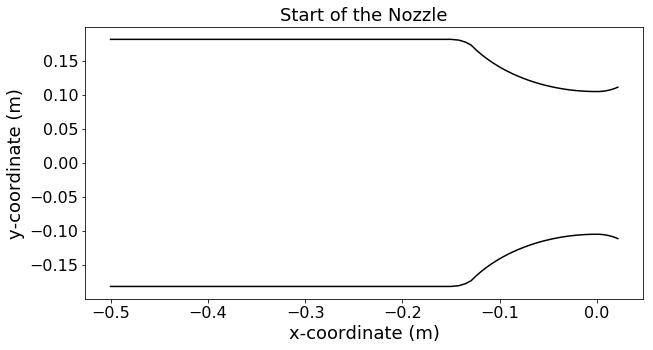

In [39]:
#Start by reading in the xml file

cwd = os.getcwd()
#print(cwd)
cf = pd.read_excel(r'contour.xlsx')
#print(cf.head())
xData = [cf.iloc[i,0] for i in range(len(cf.index))]
#print(xData)
y1Data = [cf.iloc[i,1] for i in range(len(cf.index))]
y2Data = [-data for data in y1Data]
#print(yData)

plot(xData,y1Data,y2Data,"Start of the Nozzle")

In [46]:
#Finding the throat diameter
d_t = 10
for val in y1Data:
    dis = np.abs(val - (-val))
    if dis < d_t:
        d_t = dis
#From the throat diameter, find area of the throat
A_t = np.pi * (d_t/2)**2
#Find c*
cStar = np.sqrt((R_u*T_c)/(gamma*mol))*((gamma+1)/2)**((gamma+1)/(2*(gamma-1)))
print("The mass flow through the nozzle is:")
print(rounds((P_c*A_t)/cStar),"kg/s")

The mass flow through the nozzle is:
571.917 kg/s


#### Part b)
For a given exit area $A_e$ or expansion ratio $\varepsilon$, write a code which will calculate $C_f, I_{sp}$, and thrust as a function of time for this rocket.

In [52]:
#First, the function relating expansion ratio to mach
def fMach(eps,M,gamma=1.2):
    ans = eps - ( (1/M) *
                ((2+(gamma-1)*M**2)/(gamma+1))**((gamma+1)/(2*(gamma-1))))
    return(ans)
#Next, the derivative:
def fMachPrime(eps,M,gamma=1.2):
    ans = (( (2+(gamma-1)*M**2)/(gamma+1) )**((gamma+1)/(2*gamma-2)) /
          M^2
          ) - ( ((gamma-1)*M**2 + 2)/(gamma+1) 
              )**(((gamma+1)/(2*gamma-2))-1)
    return(ans)
#The C_f equation is complicated so I'm putting it here
def cfFunction(P_c, P_e, P_a, eps, gamma=1.2):
    ans = ( ((2*gamma**2)/(gamma-1)) *
          (2/(gamma+1))**((gamma+1)/(gamma-1)) *
          (1 - (P_e/P_c)**((gamma-1)/gamma))**(1/2) +
          (P_e/P_c - P_a/P_c)*eps)
    return(ans)
def rocketStuff(mDot,A_t,eps,h=15.5*10**3,P_c = 300*10**5,gamma=1.2):
    #Find the mach at the exit
    M_e = 1 #intial guess
    for i in range(50):
        save_M = M_e
        fM = fMach(eps,M_e)
        fMP = fMachPrime(eps,M_e)
        M_e = M_e - fM/fMP
        error = np.abs(M_e-save_M)
        if error < 0.0001:
            break
    #From exit mach, find the exit pressure:
    P_e = P_c*(1 + ((gamma-1)/2)*M_e)**((-gamma)/(gamma-1))
    #Now, find ambient pressure from altitude
    atmos = atmosphere(h)
    P_a = atmos.P
    #Next, we get the coefficient of thrust
    c_f = cfFunction(P_c, P_e, P_a, eps, gamma)
    #Now, onto the thrust calculation
    F = c_f*P_c*A_t
    #Finally, the I_sp
    I_sp = F/mDot
    return([c_f,F,I_sp])

#### Part c)
Using your code, plot $C_f, I_{sp}$ as a function of time for $\varepsilon = 10$ and $15$.

In [ ]:
#Set up the parameter, t, as time and solve for heights
t = np.linspace{1,70,1000}
hVals = [h(value) for value in t]
#Set up the empty lists I will be filling with values
c_f = [[],[]]
I_sp = [[],[]]
#Epsilon values
epsilon = [10,15]
for item in epsilon:
    for jtem in h:
        
